### Prepare data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape, mapping
import mplleaflet
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon
from collections import Counter
import glob
from pygeoif import geometry
import libpysal

In [2]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 100)

Import all data

In [3]:
df_buurt = pd.read_csv("Data/buurt.csv", sep=";")

In [4]:
df_grond = pd.read_csv("Data/grond.csv", sep=";")
df_boom = pd.concat([pd.read_csv(file, dtype=str, sep=';') for file in glob.glob('Data/boom*')], 
                    axis=0, ignore_index=True).rename(columns={'OBJECTNUMMER': 'obj_nr'})
df_plan = pd.read_csv("Data/plan.csv", sep=";")
df_strat = pd.read_csv("Data/strat.csv", sep=';')

Set the coordinates for the GeoDataFrames

In [5]:
for index, value in enumerate(df_grond.WKT_LNG_LAT):
    df_grond.loc[index, "geometry"] = MultiPolygon([wkt.loads(value)])

for index, value in enumerate(df_buurt.WKT_LNG_LAT):
    df_buurt.loc[index, "geometry"] = MultiPolygon([wkt.loads(value)])
    
for index, value in enumerate(df_plan.WKT_LNG_LAT):
    df_plan.loc[index, "geometry"] = MultiPolygon([wkt.loads(value)])

for index, value in enumerate(df_strat.WKT_LNG_LAT):
    df_strat.loc[index, "geometry"] = geometry.from_wkt(df_strat.WKT_LNG_LAT[index])

df_boom["LAT2"] = df_boom.LAT.str.replace(',', '.').astype(float)
df_boom["LNG2"] = df_boom.LNG.str.replace(',', '.').astype(float)
df_boom["geometry"] = df_boom.apply(lambda x : Point([x['LNG2'],x['LAT2']]),axis=1)

In [6]:
gdf_grond = GeoDataFrame(df_grond, geometry="geometry").reset_index()
gdf_buurt = GeoDataFrame(df_buurt, geometry="geometry").reset_index()
gdf_boom = GeoDataFrame(df_boom, geometry="geometry").reset_index()
gdf_plan = GeoDataFrame(df_plan, geometry="geometry").reset_index()
gdf_strat = GeoDataFrame(df_strat, geometry=df_strat.geometry.apply(lambda g: shape(g)))

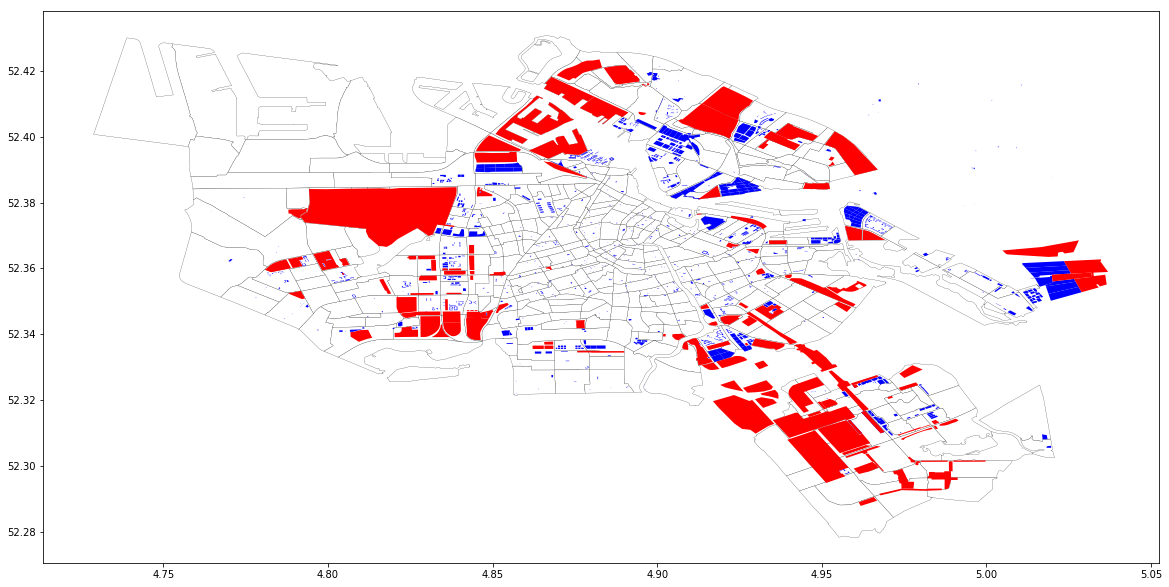

In [8]:
fig, ax = plt.subplots(figsize=(20, 20))
gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].plot(ax=ax, edgecolor='black', linewidth=0.2, color='white')
# gdf_plan.plot(ax=ax, column='aantal_bomen_index', alpha=1, cmap='RdYlGn', scheme='quantiles', legend=True)
gdf_plan.plot(ax=ax, color='b')
gdf_strat.plot(ax=ax, color='r')
# ax.get_legend()
plt.show();

In [11]:
df_strat.Fase.unique()

array(['Strategische ruimte lange termijn',
       'Overkoepelend besluit genomen', 'Strategische ruimte tot 2025',
       'Principebesluit genomen', 'Verkenning'], dtype=object)

### Buurt

Include counter of amount of trees per area

In [ ]:
df_temp = gpd.sjoin(gdf_buurt, gdf_boom, how='left', op='contains').groupby("Buurt").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'Buurt'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_buurt = gdf_buurt.merge(df_temp, on=["Buurt"])
del df_temp

Tree Index

In [ ]:
gdf_buurt["aantal_bomen_m2"] = gdf_buurt.aantal_bomen / gdf_buurt.Opp_m2
gdf_buurt["aantal_bomen_index"] = gdf_buurt.aantal_bomen_m2 / gdf_buurt.aantal_bomen_m2.max() 

Define Amsterdam: All areas except for 'Stadsdeel N'

In [ ]:
Amsterdam = gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].geometry.unary_union

### Terrains

Trees per terrain

In [ ]:
df_temp = gpd.sjoin(gdf_grond, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_grond = gdf_grond.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

In [ ]:
gdf_grond["aantal_bomen_m2"] = gdf_grond.aantal_bomen / gdf_grond.Oppervlakte_m2
gdf_grond["aantal_bomen_index"] = gdf_grond.aantal_bomen_m2 / gdf_grond.aantal_bomen_m2.max() 

Define terrains suitable for planting clusters of trees

In [ ]:
list(gdf_grond.AMScode_Oms.unique())

In [ ]:
terrains = ["Bouwterrein woonbestemming", "Bouwterrein niet-woon bestemming", 
            "Tijdelijke opslag van grond", "Semi-verhard overig terrein"]
terrein = list(gdf_grond.CBScode1_Oms.unique())

Select only those terrains that are within Amsterdam

In [ ]:
gdf_grond["InBuurt"] = gdf_grond.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

In [ ]:
gdf_temp = gdf_grond[gdf_grond.AMScode_Oms.isin(terrains)]
gdf_grond_in_buurt = gdf_temp[gdf_grond.InBuurt.isin([True])]
gdf_grond_in_buurt["aantal_bomen_index"] = gdf_grond_in_buurt.aantal_bomen_m2 / gdf_grond_in_buurt.aantal_bomen_m2.max()
del gdf_temp

### Housing plans

Trees per plan

In [ ]:
df_temp = gpd.sjoin(gdf_plan, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_plan = gdf_plan.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

In [ ]:
gdf_plan.aantal_bomen.unique()

In [ ]:
gdf_plan["area"] = gdf_plan.geometry.apply(lambda x: x.area)

In [ ]:
gdf_plan["aantal_bomen_area"] = gdf_plan.aantal_bomen / gdf_plan.area
gdf_plan["aantal_bomen_index"] = gdf_plan.aantal_bomen_area / gdf_plan.area.max() 

In [ ]:
gdf_plan["InBuurt"] = gdf_plan.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

In [ ]:
gdf_plan_in_buurt = gdf_plan[gdf_plan.InBuurt.isin([True])]

In [ ]:
gdf_plan.InBuurt[gdf_plan.InBuurt == False]

### Visualisation

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].plot(ax=ax, edgecolor='black', linewidth=0.2, color='white')
# gdf_plan.plot(ax=ax, column='aantal_bomen_index', alpha=1, cmap='RdYlGn', scheme='quantiles', legend=True)
gdf_plan.plot(ax=ax, color='b')
ax.get_legend()
plt.show();
# mplleaflet.show(fig=ax.figure, tiles="cartodb_positron")

In [ ]:
?GeoDataFrame.plot